### Figure 2 | PBMC transcriptomes exhibit a stable disease-associated global structure in sarcoidosis
UMAP embedding of variance-stabilized PBMC transcriptomes illustrating disease-associated global organization across vaccination timepoints.

SARC_DATA_ROOT was not set; using: /mnt/z

converting counts to integer mode

Saved:
/mnt/z/sarcoidosis-mrna-vaccine-transcriptomics/figures/main/Fig2_umap_txgroups.pdf
/mnt/z/sarcoidosis-mrna-vaccine-transcriptomics/figures/main/Fig2_umap_txgroups.png
/mnt/z/sarcoidosis-mrna-vaccine-transcriptomics/figures/main/Fig2_umap_hc_vs_sarc.pdf
/mnt/z/sarcoidosis-mrna-vaccine-transcriptomics/figures/main/Fig2_umap_hc_vs_sarc.png



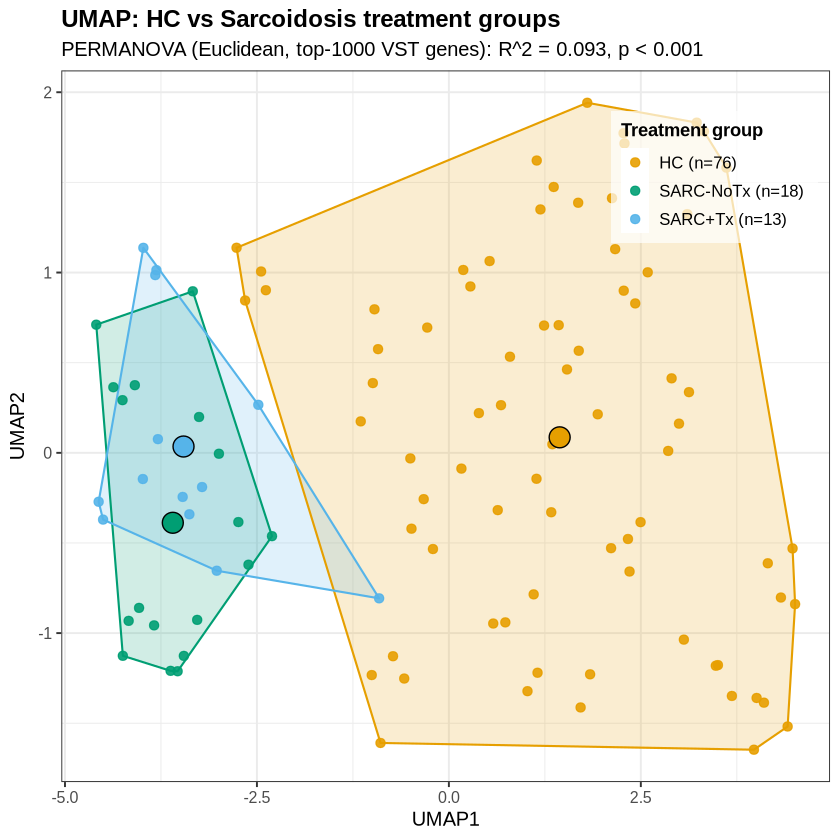

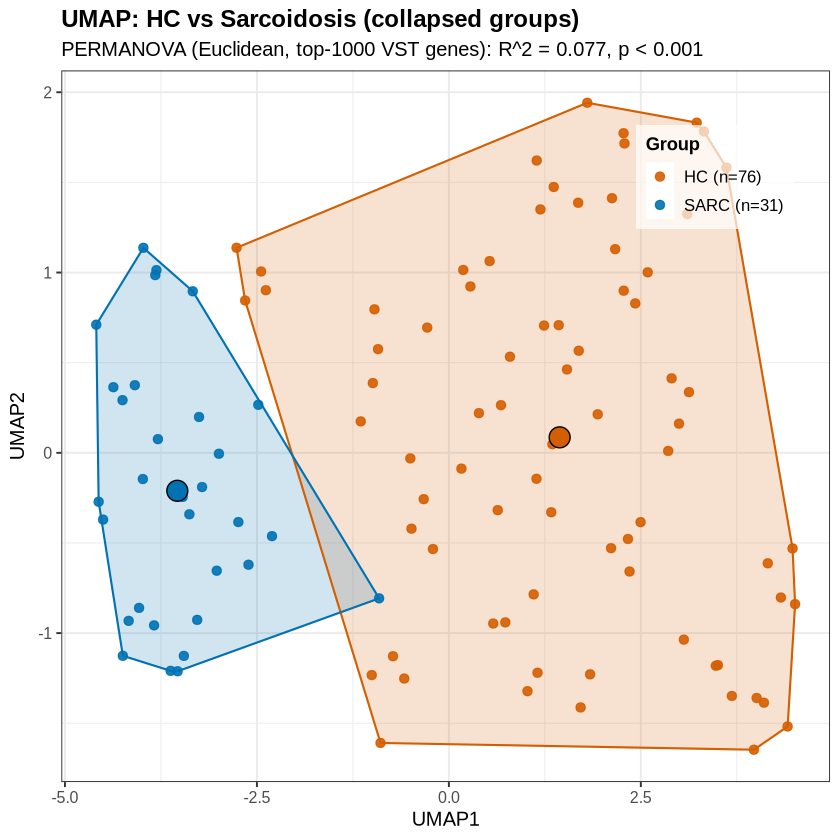

In [7]:
suppressPackageStartupMessages({
  library(DESeq2)
  library(SummarizedExperiment)
  library(dplyr)
  library(tidyr)
  library(ggplot2)
  library(readr)
  library(stringr)
  library(S4Vectors)
  library(vegan)
  library(matrixStats)
  library(tibble)
  library(uwot)
  library(here)
  library(glue)
})

set.seed(42)

SCRIPT_REL_PATH <- NULL

if (is.null(SCRIPT_REL_PATH)) {
  # Interactive / notebook fallback: do not error, but warn if here() looks wrong
  if (!file.exists(here::here("README.md")) && !dir.exists(here::here(".git"))) {
    warning(
      "Repo root not detected via here(). ",
      "If paths are wrong, set your working directory to the repo root OR set SCRIPT_REL_PATH."
    )
  }
} else {
  here::i_am(SCRIPT_REL_PATH)
}

# ----------------------------
# Inputs
# ----------------------------
DATA_ROOT <- Sys.getenv("SARC_DATA_ROOT")

if (DATA_ROOT == "") {
  # sensible default for your setup; change if needed
  DATA_ROOT <- "/mnt/z"
  Sys.setenv(SARC_DATA_ROOT = DATA_ROOT)
  message("SARC_DATA_ROOT was not set; using: ", DATA_ROOT)
}

if (!dir.exists(DATA_ROOT)) stop(glue("DATA_ROOT not found: {DATA_ROOT}"), call. = FALSE)
SE_RDS <- file.path(DATA_ROOT, "se_all_final.rds")
if (!file.exists(SE_RDS)) stop(glue("Missing input file: {SE_RDS}"), call. = FALSE)
se <- readRDS(SE_RDS)

# ----------------------------
# Outputs (tracked inside repo)
# ----------------------------
FIG_DIR <- here::here("figures", "main")
dir.create(FIG_DIR, recursive = TRUE, showWarnings = FALSE)

outfile_umap_tx_pdf <- file.path(FIG_DIR, "Fig2_umap_txgroups.pdf")
outfile_umap_tx_png <- file.path(FIG_DIR, "Fig2_umap_txgroups.png")
outfile_umap_hc_pdf <- file.path(FIG_DIR, "Fig2_umap_hc_vs_sarc.pdf")
outfile_umap_hc_png <- file.path(FIG_DIR, "Fig2_umap_hc_vs_sarc.png")

cd0 <- as.data.frame(colData(se))

# ---------- Drop ribosomal / rRNA genes ----------
rd <- as.data.frame(rowData(se))

# Determine gene symbol column
sym_col <- intersect(c("symbol", "gene_name", "GeneSymbol", "GENE", "SYMBOL"), names(rd))
if (length(sym_col) > 0) {
  gene_sym <- as.character(rd[[sym_col[1]]])
} else {
  gene_sym <- rownames(se)
}

# Optional: use gene_biotype if present
biotype_col <- intersect(c("gene_biotype", "biotype"), names(rd))
if (length(biotype_col) > 0) {
  gene_biotype <- as.character(rd[[biotype_col[1]]])
} else {
  gene_biotype <- NA_character_
}

is_ribo_symbol <- grepl("^RPL[0-9]",  gene_sym) |
                  grepl("^RPS[0-9]",  gene_sym) |
                  grepl("^MRPL[0-9]", gene_sym) |
                  grepl("^MRPS[0-9]", gene_sym) |
                  grepl("rRNA",      gene_sym, ignore.case = TRUE)

is_ribo_biotype <- if (!all(is.na(gene_biotype))) {
  grepl("ribo", gene_biotype, ignore.case = TRUE) |
    grepl("rRNA", gene_biotype, ignore.case = TRUE)
} else {
  FALSE
}

is_ribo <- is_ribo_symbol | is_ribo_biotype

se <- se[!is_ribo, ]
rm(rd, sym_col, biotype_col, gene_sym, gene_biotype, is_ribo_symbol, is_ribo_biotype, is_ribo)

# ---------- Harmonize TxGroup (expects 'm_txgroup' in colData) ----------
cd <- as.data.frame(colData(se))
stopifnot(nrow(cd) == ncol(se))

tx_candidates <- intersect(c("m_txgroup", "txgroup", "TxGroup"), names(cd))
if (length(tx_candidates) == 0) {
  stop("Could not find a TxGroup column (tried m_txgroup / txgroup / TxGroup).")
}
tx_var <- tx_candidates[1]

cd$TxGroup <- as.character(cd[[tx_var]])
cd$TxGroup[is.na(cd$TxGroup) | cd$TxGroup == ""] <- "Unknown"
colData(se) <- S4Vectors::DataFrame(cd)

# ---------- Coerce to DESeqDataSet for VST ----------
cts <- SummarizedExperiment::assay(se, "counts")
cts <- round(cts)  # ok for VST/UMAP visualization

keep_genes <- rowSums(cts) > 0
cts <- cts[keep_genes, , drop = FALSE]

dds <- DESeqDataSetFromMatrix(
  countData = cts,
  colData   = as.data.frame(colData(se)),
  design    = ~ 1
)

# ---------- VST and top-1000 variable genes ----------
vsd <- vst(dds, blind = TRUE)
mat <- assay(vsd)

vars <- matrixStats::rowVars(mat)
ord  <- order(vars, decreasing = TRUE)
topn <- min(1000, nrow(mat))
mat_top <- mat[ord[seq_len(topn)], , drop = FALSE]

# ---------- UMAP on samples ----------
set.seed(42)
umap_res <- umap(
  t(mat_top),
  n_neighbors = 15,
  min_dist    = 0.3,
  metric      = "euclidean",
  n_components = 2
)

df_umap <- as.data.frame(umap_res)
colnames(df_umap) <- c("UMAP1", "UMAP2")
df_umap$sample_id <- rownames(df_umap)

# ---------- Merge metadata ----------
cd_join <- cd
if (!"sample_id" %in% names(cd_join)) {
  cd_join <- tibble::rownames_to_column(cd_join, var = "sample_id")
}
cd_join <- cd_join %>% distinct(sample_id, .keep_all = TRUE)

df_base <- df_umap %>%
  left_join(cd_join, by = "sample_id") %>%
  mutate(
    TxGroup = if ("m_txgroup" %in% names(.)) as.character(m_txgroup) else TxGroup,
    TxGroup = coalesce(TxGroup, "Unknown")
  )

############################################################
## 1) UMAP with treatment groups: HC, Sx+Tx, Sx-NoTx
############################################################

df_tx <- df_base %>%
  filter(TxGroup != "Unknown") %>%
  mutate(TxGroup = factor(TxGroup)) %>%
  droplevels()

# ensure sensible order of levels
desired_levels <- c("HC", "Sx-NoTx", "Sx+Tx")
present_levels <- intersect(desired_levels, levels(df_tx$TxGroup))
df_tx$TxGroup <- factor(df_tx$TxGroup, levels = present_levels)

# colors keyed by true levels
tx_cols <- c(
  "HC"      = "#E69F00",  # orange
  "Sx+Tx"   = "#56B4E9",  # blue
  "Sx-NoTx" = "#009E73"   # green
)
tx_cols <- tx_cols[names(tx_cols) %in% levels(df_tx$TxGroup)]

# group counts for legend
grp_counts_tx <- df_tx %>%
  distinct(sample_id, TxGroup) %>%
  count(TxGroup, name = "n")

pretty_names_tx <- c(
  "HC"      = "HC",
  "Sx+Tx"   = "SARC+Tx",
  "Sx-NoTx" = "SARC-NoTx"
)

legend_labels_tx <- setNames(
  paste0(
    pretty_names_tx[levels(df_tx$TxGroup)],
    " (n=",
    grp_counts_tx$n[match(levels(df_tx$TxGroup), grp_counts_tx$TxGroup)],
    ")"
  ),
  levels(df_tx$TxGroup)
)

# convex hulls and centroids
hulls_tx <- df_tx %>%
  group_by(TxGroup) %>%
  filter(n() >= 3) %>%
  slice(chull(UMAP1, UMAP2)) %>%
  ungroup()

centroids_tx <- df_tx %>%
  group_by(TxGroup) %>%
  summarise(UMAP1 = mean(UMAP1), UMAP2 = mean(UMAP2), .groups = "drop")

# PERMANOVA on VST top genes, using TxGroup
mat_top_sub_tx <- mat_top[, df_tx$sample_id, drop = FALSE]
dist_mat_tx <- dist(t(mat_top_sub_tx), method = "euclidean")

perm_tx <- adonis2(dist_mat_tx ~ TxGroup, data = df_tx, permutations = 999)
R2_tx <- perm_tx$R2[1]
pv_tx <- perm_tx$`Pr(>F)`[1]

subtitle_tx <- sprintf(
  "PERMANOVA (Euclidean, top-1000 VST genes): R^2 = %.3f, p < %.3g",
  R2_tx,
  ifelse(pv_tx < 0.001, 0.001, pv_tx)
)

# UMAP plot with treatment groups
p_umap_tx <- ggplot() +
  geom_polygon(
    data = hulls_tx,
    aes(UMAP1, UMAP2, fill = TxGroup, group = TxGroup),
    alpha = 0.18,
    color = NA,
    show.legend = FALSE
  ) +
  geom_polygon(
    data = hulls_tx,
    aes(UMAP1, UMAP2, color = TxGroup, group = TxGroup),
    fill = NA,
    linewidth = 0.6,
    show.legend = FALSE
  ) +
  geom_point(
    data = df_tx,
    aes(UMAP1, UMAP2, color = TxGroup),
    size = 2.2,
    alpha = 0.9
  ) +
  geom_point(
    data = centroids_tx,
    aes(UMAP1, UMAP2, fill = TxGroup),
    color = "black",
    shape = 21,
    size = 5.5,
    stroke = 0.6,
    show.legend = FALSE
  ) +
  scale_color_manual(
    values = tx_cols,
    breaks = levels(df_tx$TxGroup),
    labels = legend_labels_tx,
    name   = "Treatment group"
  ) +
  scale_fill_manual(values = tx_cols, guide = "none") +
  labs(
    title    = "UMAP: HC vs Sarcoidosis treatment groups",
    subtitle = subtitle_tx,
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_bw(base_size = 12) +
  theme(
    plot.title = element_text(face = "bold"),
    legend.position = c(0.85, 0.85),
    legend.background = element_rect(fill = ggplot2::alpha("white", 0.7), color = NA),
    legend.key.size = unit(0.6, "cm"),
    legend.text = element_text(size = 10),
    legend.title = element_text(face = "bold", size = 11)
  )

ggsave(outfile_umap_tx_pdf, p_umap_tx, width = 6.5, height = 5.0)
ggsave(outfile_umap_tx_png, p_umap_tx, width = 7, height = 7.0, dpi = 600)

############################################################
## 2) UMAP with HC vs SARC (collapsed)
############################################################

df_hc <- df_base %>%
  mutate(
    Group2 = case_when(
      TxGroup == "HC" ~ "HC",
      TxGroup %in% c("Sx+Tx", "Sx-NoTx") ~ "SARC",
      TRUE ~ "Other"
    )
  ) %>%
  filter(Group2 %in% c("HC", "SARC")) %>%
  mutate(Group2 = factor(Group2, levels = c("HC", "SARC"))) %>%
  droplevels()

if (nlevels(df_hc$Group2) < 2) {
  stop("Fewer than two groups (HC / SARC) after collapsing. Check TxGroup values.")
}

grp_cols_hc <- c(
  "HC"   = "#D55E00",  # orange
  "SARC" = "#0072B2"   # blue
)

grp_counts_hc <- df_hc %>%
  distinct(sample_id, Group2) %>%
  count(Group2, name = "n")

legend_labels_hc <- setNames(
  paste0(
    c("HC", "SARC"),
    " (n=",
    grp_counts_hc$n[match(c("HC", "SARC"), grp_counts_hc$Group2)],
    ")"
  ),
  c("HC", "SARC")
)

hulls_hc <- df_hc %>%
  group_by(Group2) %>%
  filter(n() >= 3) %>%
  slice(chull(UMAP1, UMAP2)) %>%
  ungroup()

centroids_hc <- df_hc %>%
  group_by(Group2) %>%
  summarise(UMAP1 = mean(UMAP1), UMAP2 = mean(UMAP2), .groups = "drop")

# PERMANOVA on VST top genes, using Group2
mat_top_sub_hc <- mat_top[, df_hc$sample_id, drop = FALSE]
dist_mat_hc <- dist(t(mat_top_sub_hc), method = "euclidean")

perm_hc <- adonis2(dist_mat_hc ~ Group2, data = df_hc, permutations = 999)
R2_hc <- perm_hc$R2[1]
pv_hc <- perm_hc$`Pr(>F)`[1]

subtitle_hc <- sprintf(
  "PERMANOVA (Euclidean, top-1000 VST genes): R^2 = %.3f, p < %.3g",
  R2_hc,
  ifelse(pv_hc < 0.001, 0.001, pv_hc)
)

p_umap_hc <- ggplot() +
  geom_polygon(
    data = hulls_hc,
    aes(UMAP1, UMAP2, fill = Group2, group = Group2),
    alpha = 0.18,
    color = NA,
    show.legend = FALSE
  ) +
  geom_polygon(
    data = hulls_hc,
    aes(UMAP1, UMAP2, color = Group2, group = Group2),
    fill = NA,
    linewidth = 0.6,
    show.legend = FALSE
  ) +
  geom_point(
    data = df_hc,
    aes(UMAP1, UMAP2, color = Group2),
    size = 2.2,
    alpha = 0.9
  ) +
  geom_point(
    data = centroids_hc,
    aes(UMAP1, UMAP2, fill = Group2),
    color = "black",
    shape = 21,
    size = 5.5,
    stroke = 0.6,
    show.legend = FALSE
  ) +
  scale_color_manual(
    values = grp_cols_hc,
    breaks = levels(df_hc$Group2),
    labels = legend_labels_hc,
    name   = "Group"
  ) +
  scale_fill_manual(values = grp_cols_hc, guide = "none") +
  labs(
    title    = "UMAP: HC vs Sarcoidosis (collapsed groups)",
    subtitle = subtitle_hc,
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_bw(base_size = 12) +
  theme(
    plot.title = element_text(face = "bold"),
    legend.position = c(0.85, 0.85),
    legend.background = element_rect(fill = ggplot2::alpha("white", 0.7), color = NA),
    legend.key.size = unit(0.6, "cm"),
    legend.text = element_text(size = 10),
    legend.title = element_text(face = "bold", size = 11)
  )

ggsave(outfile_umap_hc_pdf, p_umap_hc, width = 6.5, height = 5.0)
ggsave(outfile_umap_hc_png, p_umap_hc, width = 7, height = 7.0, dpi = 600)

message("Saved:\n",
        outfile_umap_tx_pdf, "\n", outfile_umap_tx_png, "\n",
        outfile_umap_hc_pdf, "\n", outfile_umap_hc_png)

p_umap_tx
p_umap_hc
